In [18]:
import numpy as np
import pandas as pd
from typing import Any, cast, Dict

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Datasets

Copies of the dataset, each with a different scaler applies, are generated and stored for usage in training.

In [19]:
from read_data import read_datasets
from data_cleaning import prep_dataframe

# dep_var = "Log(Rmax)"
dep_var = "Log(Efficiency)"
use_crossval = True

all_data = read_datasets()
combined_data = prep_dataframe(all_data, dep_var)


Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.20GHz' @ Earth Simulator, 2009
Unknown processor: 'Xeon EM64T', full name: 'Xeon EM64T  3.60GHz' @ Thunderbird, 2006


In [20]:
from training import train_test_random, split_x_y
from data_cleaning import DataCleaner
from models import scalers

datasets = {}
cleaners = {}
for scaler_name, scaler in scalers.items():
    cleaner = DataCleaner(scaler, dep_var)
    data = cleaner.fit_transform(combined_data.copy())
    data = data.drop(columns="Date")

    if use_crossval:
        # Need holdout split, but not train test b/c cross val will do them
        non_holdout, holdout = train_test_random(data, 0.2)
        datasets[scaler_name] = split_x_y([non_holdout, holdout], dep_var)
        cleaners[scaler_name] = cleaner
    else:
        # Do splits for all data
        non_holdout, holdout = train_test_random(data, 0.2)
        train, test = train_test_random(non_holdout, 0.2)
        datasets[scaler_name] = split_x_y([train, test, holdout], dep_var)
        cleaners[scaler_name] = cleaner


Filtered duplicates to go from 5332 rows to 1530
Filtered duplicates to go from 5332 rows to 1530
Filtered duplicates to go from 5332 rows to 1530


In [21]:
from training import calc_stats
from tqdm.auto import tqdm
from sklearn.metrics import r2_score

from models import models
from kfold import cross_validate

cols = ["name", "scaler", "r2", "mae", "mape", "mse"]
if use_crossval:
    cols += ["cv_r2", "std", "min", "max", "best_estimator"]
    results = pd.DataFrame(columns=cols)
else:
    results = pd.DataFrame(columns=cols)

for model_name, model in tqdm(models.items()):
    tqdm.write(model_name)
    for scaler_name in scalers.keys():
        if use_crossval:
            [non_holdout, holdout] = datasets[scaler_name]
            (X, y) = non_holdout

            # Run cross validation
            r2, best_estimator = cross_validate(model, X, y, scoring=r2_score, cv=10)

            # Calc stats for holdout set using the best estimator
            pred_y = best_estimator.predict(holdout[0])
            result = calc_stats(holdout[1], pred_y, print_res=False)

            # Add in data specific to cross validation + name and scaler info
            result |= {
                "name": model_name,
                "scaler": scaler_name,
                "cv_r2": r2.mean(),
                "std": r2.std(),
                "min": r2.min(),
                "max": r2.max(),
                # "best_estimator": best_estimator,
            }
        else:
            train, test, holdout = datasets[scaler_name]
            model.fit(train[0], train[1])

            pred_y = model.predict(test[0])
            result = calc_stats(test[1], pred_y, print_res=False)
            result = cast(Dict[str, Any], result)
            result["name"] = model_name
            result["scaler"] = scaler_name

        results = results.append(result, ignore_index=True)


  0%|          | 0/23 [00:00<?, ?it/s]

lr_1
knn_1
knn_2
knn_3
knn_4
knn_5
knn_tuned
svr_1
svr_tuned
rf_1
rf_2
rf_3
rf_tuned
gbt_1
gbt_2
gbt_3
gbt_4
gbt_5
mlp_1


/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimize

dnn1_1
dnn2_1
xgb_1
lgbm_1


In [86]:
# Take only the maximum scaler config for each model
max_indices = results.groupby(["name"])["r2"].idxmax()
maximums = results.loc[max_indices]
maximums.sort_values(by="r2", ascending=False)


,Unnamed: 0,Unnamed: 0.1,name,scaler,r2,mae,mape,mse,cv_r2,std,min,max,best_estimator
56,56,56,gbt_5,MinMax,0.952442,0.209978,0.034406,0.094508,0.949359,0.020764,0.907211,0.974588,NaN
60,60,60,dnn1_1,Robust,0.947350,0.197644,0.033183,0.104626,0.938646,0.016131,0.912820,0.961138,NaN
67,67,67,xgb_1,Standard,0.947348,0.203861,0.033411,0.104631,0.951803,0.018942,0.917040,0.978450,NaN
31,31,31,rf_1,Standard,0.945301,0.211926,0.034477,0.108697,0.946001,0.020398,0.905624,0.972065,NaN
35,35,35,rf_2,MinMax,0.945106,0.210850,0.034269,0.109085,0.946259,0.019724,0.907812,0.973172,NaN
39,39,39,rf_tuned,Robust,0.944870,0.211274,0.034318,0.109555,0.946266,0.019603,0.907880,0.972763,NaN
71,71,71,lgbm_1,MinMax,0.944433,0.216353,0.035219,0.110423,0.938711,0.017601,0.893957,0.959743,NaN
51,51,51,gbt_4,Robust,0.943768,0.230994,0.037730,0.111744,0.943207,0.019257,0.906132,0.970122,NaN
50,50,50,gbt_3,MinMax,0.927415,0.265646,0.043345,0.144241,0.930779,0.021536,0.885569,0.962658,NaN
46,46,46,gbt_2,Standard,0.907303,0.308647,0.050804,0.184207,0.914271,0.019361,0.880917,0.948006,NaN


In [31]:
from preservation import save_model

for index, row in maximums.iterrows():
    name: str = row["name"]  # type: ignore
    best_model = row["best_estimator"]
    best_scaler = cleaners[row["scaler"]]  # type: ignore

    save_model(name, best_model, best_scaler, dep_var)


<class 'models.DNN1'>
INFO:tensorflow:Assets written to: ml/models/dnn1_1/rmax/assets
<class 'models.DNN2'>
INFO:tensorflow:Assets written to: ml/models/dnn2_1/rmax/assets
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Sklearn: Model written to ml/models/gbt_1/rmax.pkl
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Sklearn: Model written to ml/models/gbt_2/rmax.pkl
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Sklearn: Model written to ml/models/gbt_3/rmax.pkl
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Sklearn: Model written to ml/models/gbt_4/rmax.pkl
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Sklearn: Model written to ml/models/gbt_5/rmax.pkl
<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Sklearn: Model written to ml/models/knn_1/rmax.pkl
<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Sklearn: Model written to ml/models/knn_2/rmax.pkl
<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Sklear

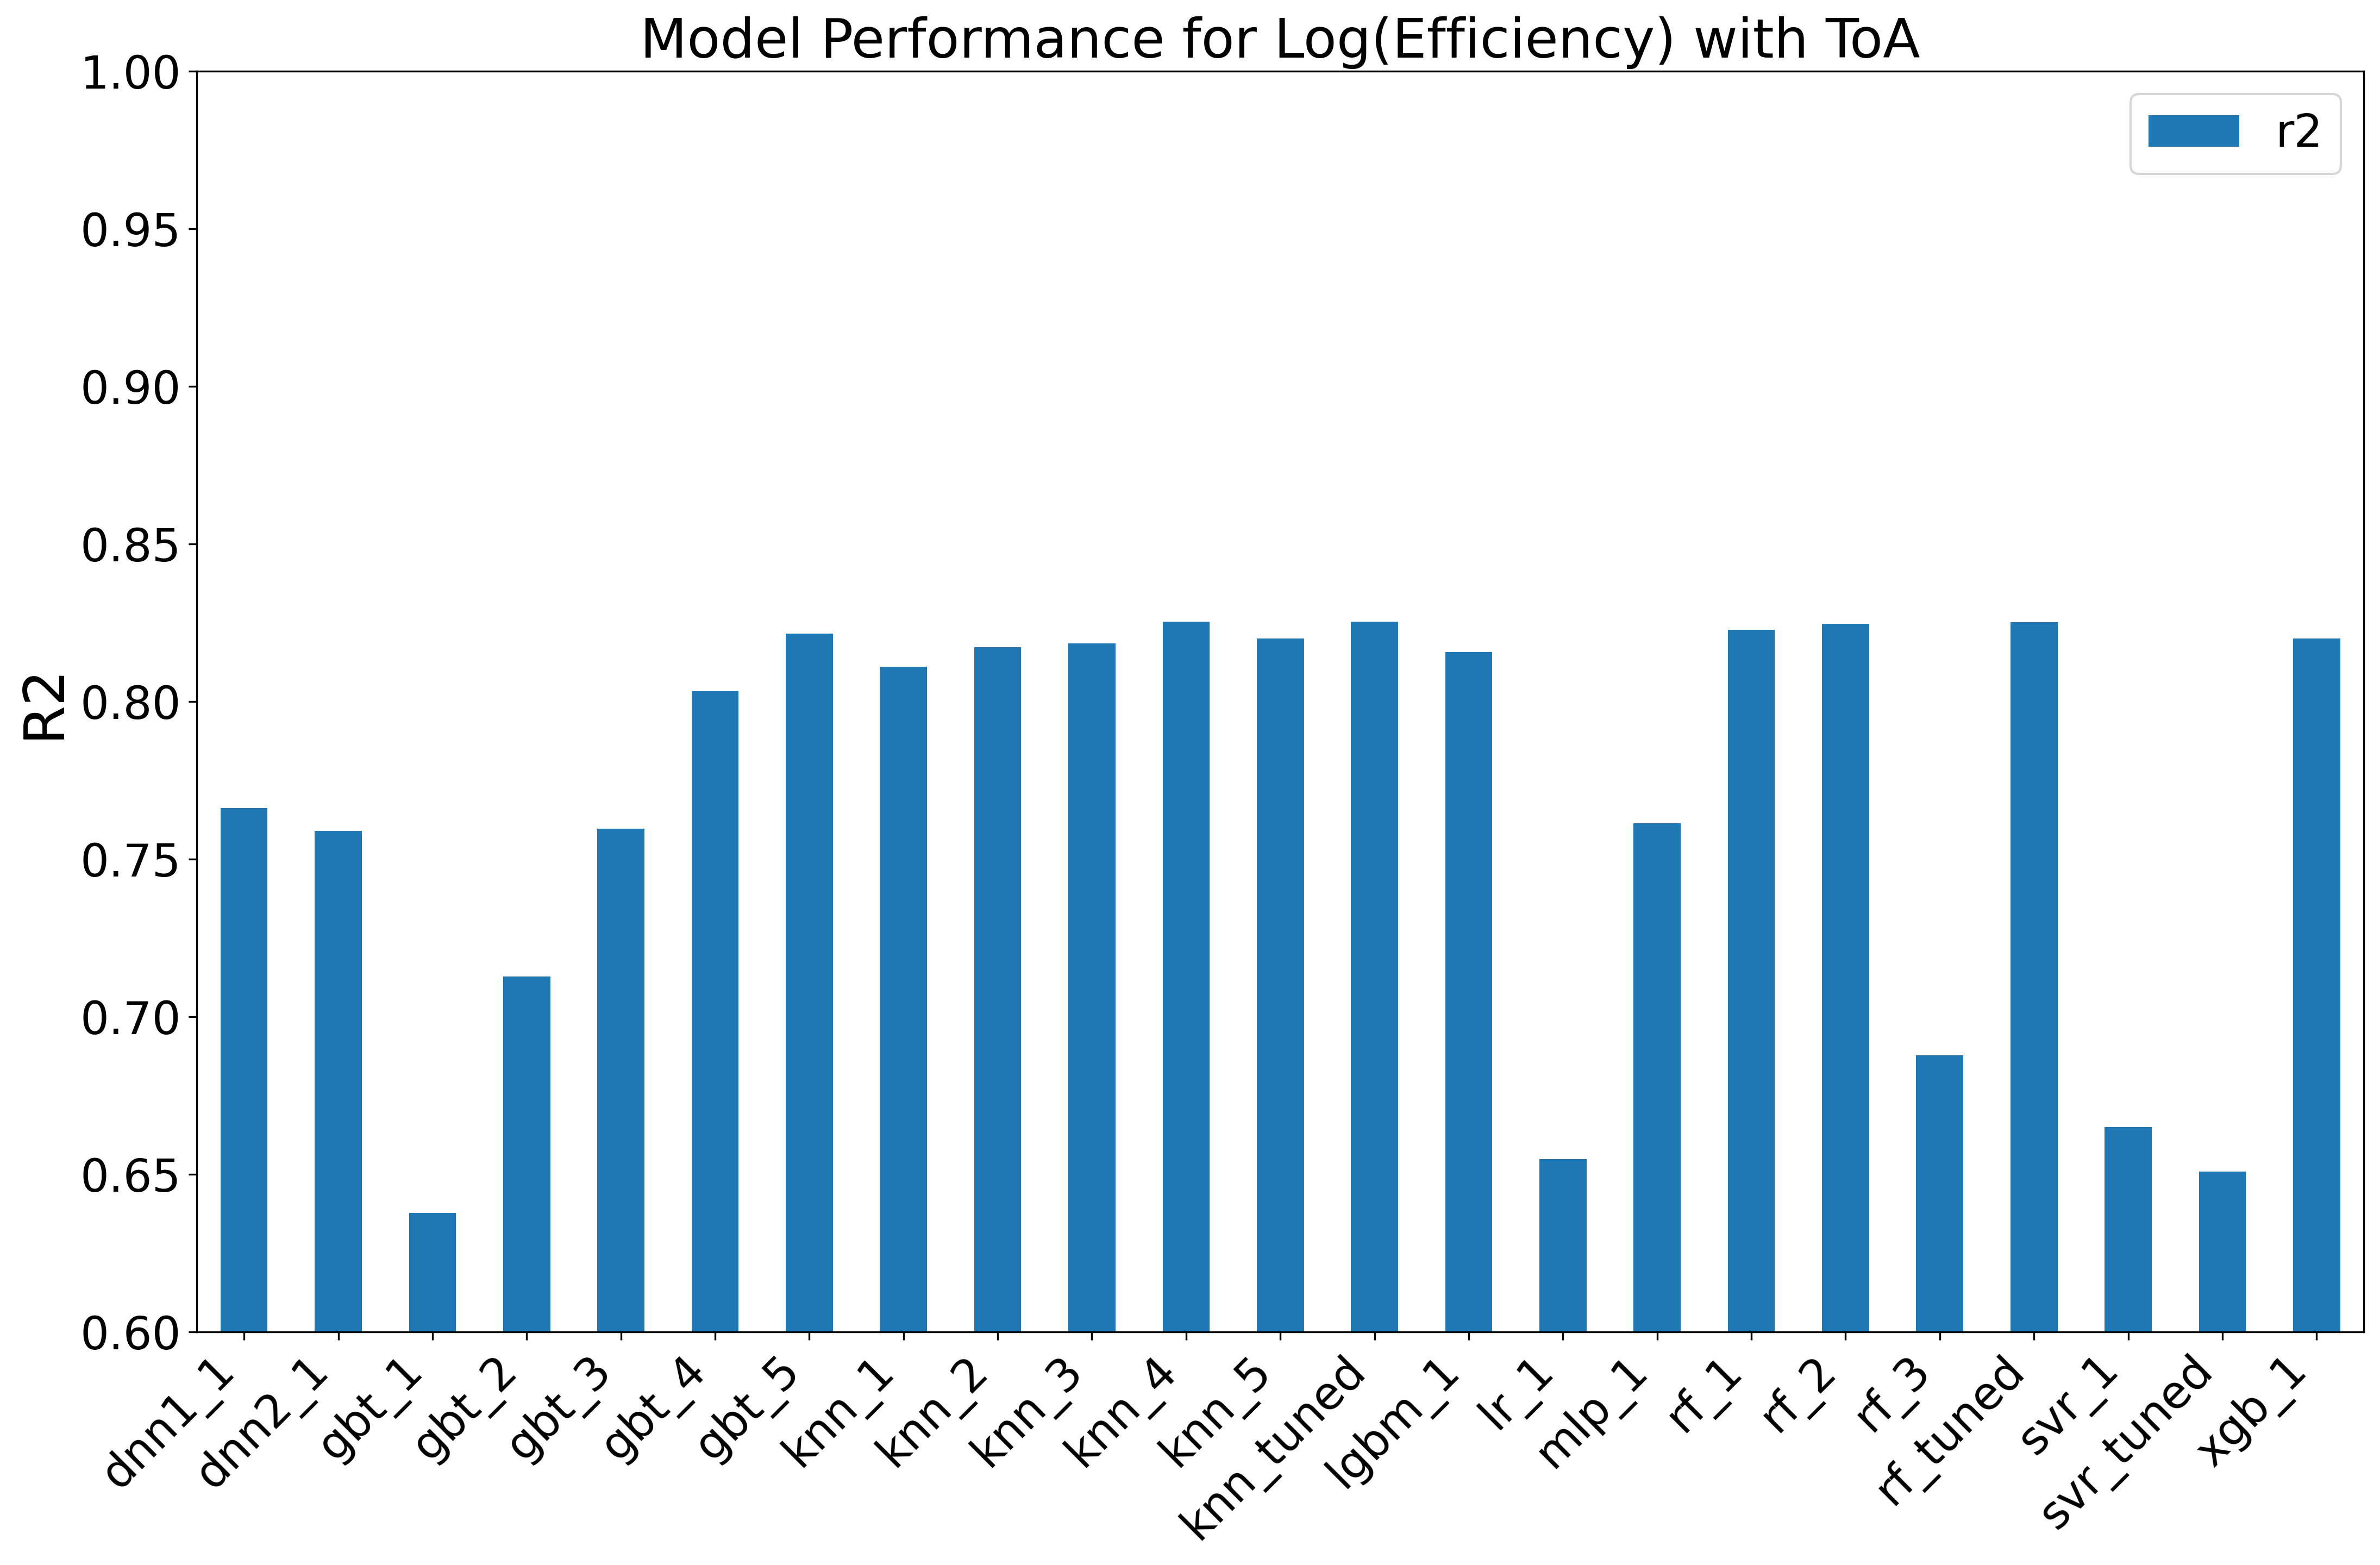

In [82]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE + 5)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE, dpi=300)  # fontsize of the figure title

axis = maximums.plot.bar(x="name", y="r2", figsize=(
    15, 10), ylabel="R2", title="Model Performance for Log(Efficiency) with ToA", xlabel="")
axis.set_xticklabels(labels=maximums["name"], rotation=45, ha="right")
# axis.set_ylim(bottom=0.75, top=1)
axis.set_ylim(bottom=0.6, top=1)
axis.figure.tight_layout()


In [83]:
from datetime import datetime
import pathlib

now = datetime.now()
dt_string = now.strftime(r"%m-%d-%YT%I-%M-%S%p")

all_identifier = f"all_results_toa_{dt_string}"
best_identifier = f"best_results_toa_{dt_string}"
out_dir = pathlib.Path("out")
all_csv_path = out_dir / (all_identifier + ".csv")
best_csv_path = out_dir / (best_identifier + ".csv")
img_path = out_dir / (best_identifier + ".png")

results.to_csv(all_csv_path)
maximums.to_csv(best_csv_path)
axis.figure.set_facecolor((1, 1, 1, 1))
axis.figure.savefig(img_path)


In [94]:
import pathlib

out_dir = pathlib.Path("out")
# dt_string = "04-21-2022T12-01-09PM"
dt_string = "04-21-2022T11-56-41AM"
all_identifier = f"all_results_toa_{dt_string}"
best_identifier = f"best_results_toa_{dt_string}"
all_csv_path = out_dir / (all_identifier + ".csv")
best_csv_path = out_dir / (best_identifier + ".csv")

results = pd.read_csv(all_csv_path)
maximums = pd.read_csv(best_csv_path)

In [95]:
maximums.sort_values(by="r2", ascending=False)[["name", "r2"]]


,name,r2
10,knn_4,0.825388
12,knn_tuned,0.825388
19,rf_tuned,0.825112
17,rf_2,0.824716
16,rf_1,0.822775
6,gbt_5,0.821500
11,knn_5,0.819991
22,xgb_1,0.819949
9,knn_3,0.818421
8,knn_2,0.817169
